In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense, Flatten, ConvLSTM1D,ConvLSTM2D, MaxPooling2D
from keras.layers import Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
biological_data = pd.read_csv("biological_data.csv").drop('Unnamed: 0', axis=1)

In [3]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

human_data = biological_data.copy()
human_data['X2'] = human_data.apply(lambda x: getKmers(x['X2']), axis=1)
human_data['X3'] = human_data.apply(lambda x: getKmers(x['X3']), axis=1)

human_data_X2 = list(human_data['X2'])
human_data_X3 = list(human_data['X3'])
for item in range(len(human_data)):
    human_data_X2[item] = ' '.join(human_data_X2[item])
    human_data_X3[item] = ' '.join(human_data_X3[item])
    
y_data = human_data.iloc[:, 0].values
#Normalize y data
y_data = np.array(normalize([y_data]))
y_data = y_data.reshape(-1)

# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
cv = CountVectorizer(ngram_range=(4,4))
X2 = cv.fit_transform(human_data_X2)
X3 = cv.fit_transform(human_data_X3)

X2X3 = np.concatenate((X2.toarray(), X3.toarray()), axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X2X3, y_data, test_size = 0.2, random_state = 42)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

In [4]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.75
                                            , min_lr=0.00001)

In [5]:
x_train = X_train.reshape((X_train.shape[0], 1, 429, 1))
x_valid = X_valid.reshape((X_valid.shape[0], 1, 429, 1))

In [6]:
# ConvLSTM 1D
CL1Dmodel = Sequential()
CL1Dmodel.add(ConvLSTM1D(filters=128, kernel_size=(1), input_shape=(1, 429, 1)))
CL1Dmodel.add(Flatten())
CL1Dmodel.add(Dense(1))
CL1Dmodel.compile(optimizer='adam', loss='mse',metrics=['mse'])
          
history = CL1Dmodel.fit(x_train, y_train, epochs=150, batch_size=8
                        , validation_data=(x_valid, y_valid)
                        , callbacks=[learning_rate_reduction])

2023-01-16 17:45:27.926008: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 17:45:27.926446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 17:45:27.930216: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 17:45:27.930644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-16 17:45:27.931130: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Epoch 1/150


2023-01-16 17:45:31.062647: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-01-16 17:45:31.672940: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


200/200 [==============================] - 5s 7ms/step - loss: 0.0016 - mse: 0.0016 - val_loss: 3.7023e-04 - val_mse: 3.7023e-04 - lr: 0.0010
Epoch 2/150
200/200 [==============================] - 1s 6ms/step - loss: 4.2234e-04 - mse: 4.2234e-04 - val_loss: 5.2657e-04 - val_mse: 5.2657e-04 - lr: 0.0010
Epoch 3/150
191/200 [===========================>..] - ETA: 0s - loss: 3.7395e-04 - mse: 3.7395e-04
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
200/200 [==============================] - 1s 6ms/step - loss: 3.7115e-04 - mse: 3.7115e-04 - val_loss: 3.7635e-04 - val_mse: 3.7635e-04 - lr: 0.0010
Epoch 4/150
200/200 [==============================] - 1s 6ms/step - loss: 3.0645e-04 - mse: 3.0645e-04 - val_loss: 3.0644e-04 - val_mse: 3.0644e-04 - lr: 7.5000e-04
Epoch 5/150
191/200 [===========================>..] - ETA: 0s - loss: 2.9619e-04 - mse: 2.9619e-04
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.
200/200 [===================

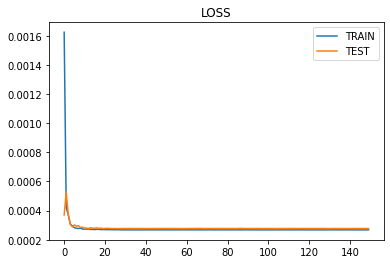

In [7]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("LOSS")
plt.legend(["TRAIN" , "TEST"])
plt.show()

13/13 [==============================] - 0s 3ms/step


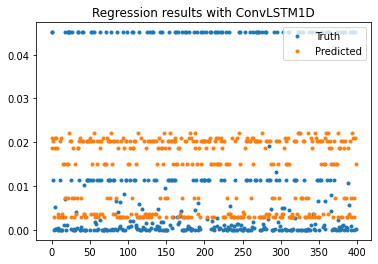

In [8]:
y_pred = CL1Dmodel.predict(x_valid)
x = np.arange(399)
plt.figure()
plt.plot(x,y_valid, '.')
plt.plot(x,y_pred, '.')
plt.legend(["Truth", "Predicted"], loc ="upper right")
plt.title("Regression results with ConvLSTM1D")
plt.show()

In [9]:
# ConvLSTM2D with text prcoessing
codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
    char_dict = {}
    for index, val in enumerate(codes):
        char_dict[val] = index+1

    return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

def integer_encoding(data):
    encode_list = []
    for row in data.values:
        row_encode = []
        for code in row:
            row_encode.append(char_dict.get(code, 0))
        encode_list.append(np.array(row_encode))
  
    return encode_list

data = biological_data.copy()
X2_encode = integer_encoding(data['X2'])
X3_encode = integer_encoding(data['X3']) 

X2_encode = np.array(normalize(X2_encode))
X2_encode = np.concatenate((X2_encode, np.zeros((1995,2))), axis=1)
X3_encode = np.array(normalize(X2_encode))

x2x3 = np.empty((1995, 2, 92))
for i in range(0,1995):
    x2x3[i][0] = X2_encode[i] 
    x2x3[i][1] = X3_encode[i]

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(x2x3, y_data, test_size = 0.2, random_state = 42)
# X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
X_train = np.reshape(X_train, (X_train.shape[0], 1, 2, 92, 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], 1, 2, 92, 1))

In [11]:
CL2Dmodel = Sequential()
CL2Dmodel.add(ConvLSTM2D(filters=62, kernel_size=(2,6), activation='relu', input_shape=(1, 2, 92, 1)))
CL2Dmodel.add(Flatten())
CL2Dmodel.add(Dense(1))
CL2Dmodel.compile(optimizer='adam', loss='mse',metrics=['mse'])
          
history = CL2Dmodel.fit(X_train, y_train, epochs=150, batch_size=64, validation_data=(X_valid, y_valid))

Epoch 1/150
25/25 [==============================] - 2s 19ms/step - loss: 3.5397e-04 - mse: 3.5397e-04 - val_loss: 3.2527e-04 - val_mse: 3.2527e-04
Epoch 2/150
25/25 [==============================] - 0s 6ms/step - loss: 3.2904e-04 - mse: 3.2904e-04 - val_loss: 3.2467e-04 - val_mse: 3.2467e-04
Epoch 3/150
25/25 [==============================] - 0s 6ms/step - loss: 3.2428e-04 - mse: 3.2428e-04 - val_loss: 3.2619e-04 - val_mse: 3.2619e-04
Epoch 4/150
25/25 [==============================] - 0s 6ms/step - loss: 3.2490e-04 - mse: 3.2490e-04 - val_loss: 3.2187e-04 - val_mse: 3.2187e-04
Epoch 5/150
25/25 [==============================] - 0s 6ms/step - loss: 3.2019e-04 - mse: 3.2019e-04 - val_loss: 3.1850e-04 - val_mse: 3.1850e-04
Epoch 6/150
25/25 [==============================] - 0s 6ms/step - loss: 3.2288e-04 - mse: 3.2288e-04 - val_loss: 3.2322e-04 - val_mse: 3.2322e-04
Epoch 7/150
25/25 [==============================] - 0s 6ms/step - loss: 3.1510e-04 - mse: 3.1510e-04 - val_loss: 3.1

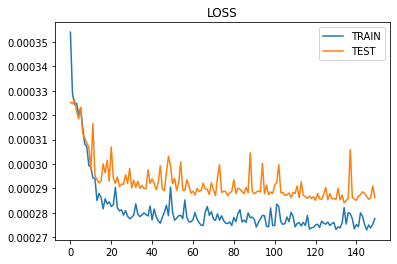

In [12]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("LOSS")
plt.legend(["TRAIN" , "TEST"])
plt.show()

13/13 [==============================] - 0s 1ms/step


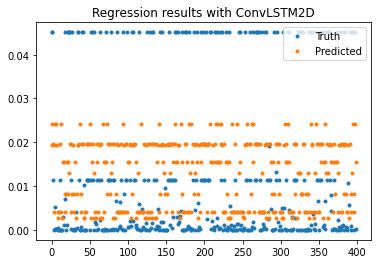

In [13]:
y_pred = CL2Dmodel.predict(X_valid)
x = np.arange(399)
plt.figure()
plt.plot(x,y_valid, '.')
plt.plot(x,y_pred, '.')
plt.legend(["Truth", "Predicted"], loc ="upper right")
plt.title("Regression results with ConvLSTM2D")
plt.show()